# 1. Project 3: Non-Parametric Methods following the previous projects

Project 3: Non-Parametric Methods
- Enrique Almazán Sánchez
- Judith Briz Galera

## Imports

In [1]:
import time

import pandas as pd
import numpy as np
from scipy import stats

import utils as u

# Visualizing
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Feature Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Preprocessing
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler, 
    StandardScaler, 
    RobustScaler
)

# Figures of merit
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    auc, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix, 
    classification_report, 
    r2_score, 
    mean_absolute_error, 
    mean_squared_error
)

# Models to be implemented
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    VotingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
#from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet


# Cross-validation
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    StratifiedKFold,
    RepeatedKFold,
    KFold
)

from sklearn.multiclass import OneVsRestClassifier

In [2]:
import warnings

# Desactivar todas las advertencias (no se recomienda a menos que sea necesario)
warnings.filterwarnings("ignore")

## 1. Dataset import

First of all, we import the clean dataset we obtained in Project 1, which was already split in train and test, but without normalizing it.

In [3]:
# Import train set
train = pd.read_csv('train_data_bcl.csv')
# Import test set
test = pd.read_csv('test_data_bcl.csv')

Now divide each of the sets in features and target variable.

In [4]:
# Divide train set in features and target variable
X_train_prime, y_train_prime = (train.drop('Status', axis=1), train['Status'])
# Divide test set in features and target variable
X_test_prime, y_test_prime = (test.drop('Status', axis=1), test['Status'])

## 2. Feature Selection

First of all, the column 'Patient Identifier' is eliminated, as it does not give any valuable information.

In [5]:
# For train
patient_id_train = X_train_prime['Patient Identifier']
patient_id_train.columns = 'Patient Identifier'
X_train_prime = X_train_prime.drop('Patient Identifier', axis=1)
# For test
patient_id_test = X_test_prime['Patient Identifier']
patient_id_test.columns = 'Patient Identifier'
X_test_prime = X_test_prime.drop('Patient Identifier', axis=1)

Now, different methods of feature selection are performed, in order to take the one that gives better performance.

### 2.1. Correlation between features and their importance regarding the estimation of the target variable.

First, we compute the importance of each feature.

In [6]:
# Create and fit the classifier
clf = ExtraTreesClassifier(n_estimators=50, random_state=10)
clf = clf.fit(X_train_prime, y_train_prime)

# Create and fit SelectFromModel with feature names
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train_prime)

# Get feature importances for all features
importances = dict(zip(X_train_prime.columns, clf.feature_importances_))

And we show the results.

In [7]:
# Find the maximum width of the keys for formatting
max_key_width = max(map(len, importances.keys()))

for key, value in importances.items():
    print(f"{key.ljust(max_key_width)}  {round(value, 3)}")

Jitter in %                                                                 0.036
Absolute Jitter in microseconds                                             0.033
Jitter as relative amplitude perturbation                                   0.045
Jitter as 5-point period perturbation                                       0.041
Absolute Jitter difference between Jitter Cycles                            0.048
Shimmer in %                                                                0.033
Absolute Shimmer in decibels (dB)                                           0.035
Shimmer as 3 point amplitude perturbation                                   0.033
Shimmer as 5 point amplitude perturbation                                   0.038
Shimmer as 11 point amplitude perturbation                                  0.047
Shimmer as Average absolute difference between amplitude of shimmer cycles  0.032
Autocorrelation between NHR and HNR                                         0.038
Noise to Harmoni

Also, the correlation matrix is shown, to remember that we have groups of high correlated groups.

<AxesSubplot:>

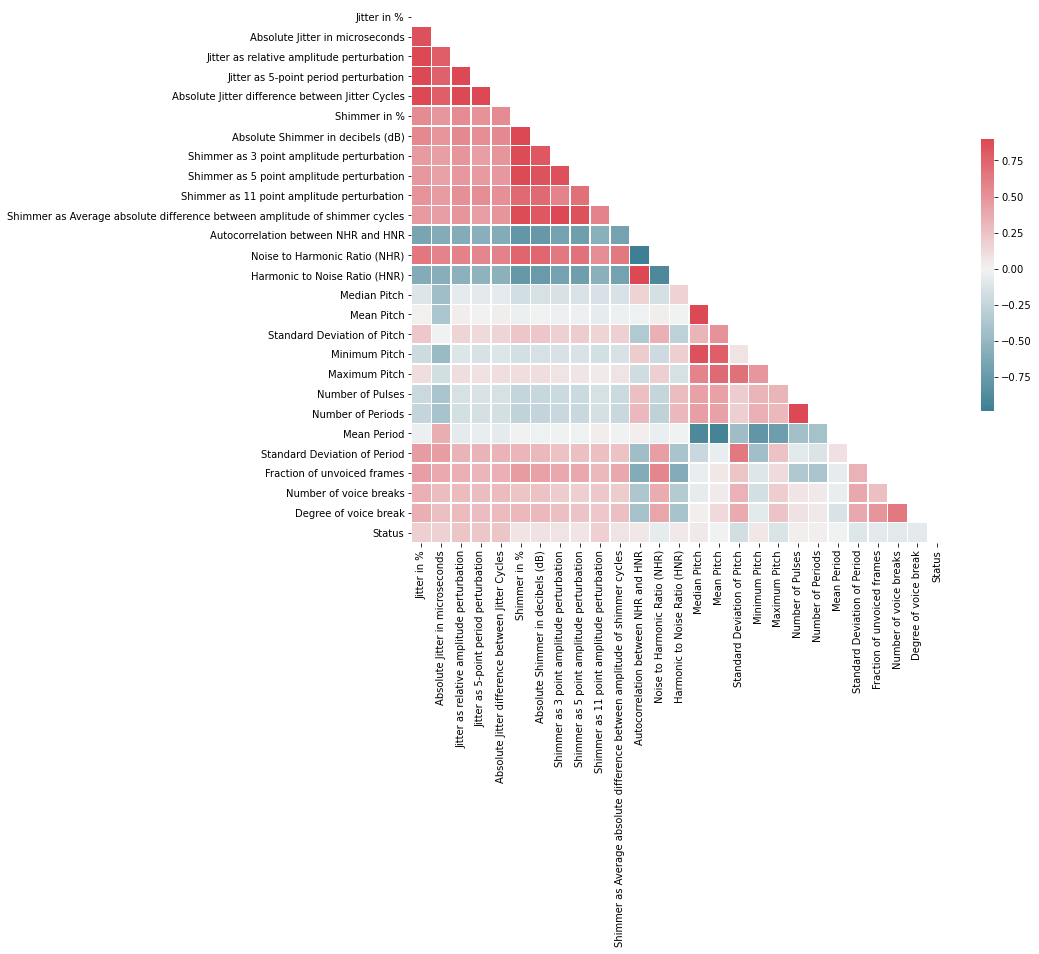

In [8]:
# We ignore the first column as it is like a patient id
df_corr = train.drop(["Patient Identifier"], axis=1)

# Compute the correlation matrix
corr = df_corr.corr()

# Gnerate a mask with numpy that ignores the superior triangular part (as it is symetrical) and the diagonal
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Prepare the figure with Matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)


# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Thus, we show the different groups of features which have high correletion between them.

In [9]:
# Creamos una lista con las columnas/características
columns = list(X_train_prime.columns)

# Creamos un diccionario para almacenar los grupos de columnas altamente correlacionadas
correlation_groups = {}

# Iteramos sobre las columnas de la lista creada previamente
for column in columns:
    
    # Flag para indicar si la columna está asignada a un grupo existente
    assigned_to_group = False
    
    # Iteramos sobre los grupos existentes
    for group, group_columns in correlation_groups.items():
        
        # Calculamos la correlación promedio entre la columna actual y las columnas del grupo
        avg_correlation = sum(X_train_prime[column].corr(X_train_prime[col]) for col in group_columns) / len(group_columns)
        
        # Si la correlación promedio es mayor que un umbral, asignamos la columna al grupo
        if avg_correlation > 0.8 or avg_correlation < -0.75:
            correlation_groups[group].append(column)
            assigned_to_group = True
            break
    
    # Si la columna no se asigna a un grupo existente, creamos un nuevo grupo
    if not assigned_to_group:
        correlation_groups[column] = [column]

In [10]:
# Showing the resulting groups
for i, (group, group_columns) in enumerate(correlation_groups.items()):
    print(f"\n{i+1} Group {group}: {group_columns}")


1 Group Jitter in %: ['Jitter in %', 'Absolute Jitter in microseconds', 'Jitter as relative amplitude perturbation', 'Jitter as 5-point period perturbation', 'Absolute Jitter difference between Jitter Cycles']

2 Group Shimmer in %: ['Shimmer in %', 'Absolute Shimmer in decibels (dB)', 'Shimmer as 3 point amplitude perturbation', 'Shimmer as 5 point amplitude perturbation', 'Shimmer as Average absolute difference between amplitude of shimmer cycles']

3 Group Shimmer as 11 point amplitude perturbation: ['Shimmer as 11 point amplitude perturbation']

4 Group Autocorrelation between NHR and HNR: ['Autocorrelation between NHR and HNR', 'Noise to Harmonic Ratio (NHR)']

5 Group Harmonic to Noise Ratio (HNR): ['Harmonic to Noise Ratio (HNR)']

6 Group Median Pitch: ['Median Pitch', 'Mean Pitch', 'Minimum Pitch', 'Mean Period']

7 Group Standard Deviation of Pitch: ['Standard Deviation of Pitch']

8 Group Maximum Pitch: ['Maximum Pitch']

9 Group Number of Pulses: ['Number of Pulses', 'Numb

Now we select one feature per correlation group, which is the one with more importance per group.

In [11]:
# Create a list to add the best features
best_features = []

# Iterating over the correlation_groups as a dictionary of groups of correlated features
# (the created in the previous example)
for group, group_columns in correlation_groups.items():
    # Find the feature with the highest importance in the current group
    best_features.append(max(group_columns, key=lambda x: importances[x]))

We show the selected features.

In [12]:
# Show the features selected
for i, feature in enumerate(best_features):
    print(f"Best feature for group {i+1}: {feature}")

Best feature for group 1: Absolute Jitter difference between Jitter Cycles
Best feature for group 2: Shimmer as 5 point amplitude perturbation
Best feature for group 3: Shimmer as 11 point amplitude perturbation
Best feature for group 4: Noise to Harmonic Ratio (NHR)
Best feature for group 5: Harmonic to Noise Ratio (HNR)
Best feature for group 6: Median Pitch
Best feature for group 7: Standard Deviation of Pitch
Best feature for group 8: Maximum Pitch
Best feature for group 9: Number of Pulses
Best feature for group 10: Standard Deviation of Period
Best feature for group 11: Fraction of unvoiced frames
Best feature for group 12: Number of voice breaks
Best feature for group 13: Degree of voice break


In [13]:
clf = clf.fit(X_train_prime[best_features], y_train_prime)

# Get feature importances for all features
importances = dict(zip(X_train_prime[best_features].columns, clf.feature_importances_))

for key, value in importances.items():
    print(f"{key.ljust(max_key_width)}  {round(value, 3)}")

Absolute Jitter difference between Jitter Cycles                            0.116
Shimmer as 5 point amplitude perturbation                                   0.08
Shimmer as 11 point amplitude perturbation                                  0.088
Noise to Harmonic Ratio (NHR)                                               0.07
Harmonic to Noise Ratio (HNR)                                               0.072
Median Pitch                                                                0.087
Standard Deviation of Pitch                                                 0.087
Maximum Pitch                                                               0.097
Number of Pulses                                                            0.072
Standard Deviation of Period                                                0.072
Fraction of unvoiced frames                                                 0.073
Number of voice breaks                                                      0.041
Degree of voice br

In the case we want a more robust feature selection, we can run the following code to only select the three most important features.

In [14]:
#top = u.top_features(importances, 3)
#print(top)

## 3. Model selection and training

### Base models - Proposed algorithms

We will use the following base models to perform an initial evaluation and identify those that best fit our dataset. The explanations of each of them are in the document 'README'.

1. k-Nearest Neighbors (KNN)

2. Decision Tree Classifier (DTC)

3. Random Forest Classifier (RFC) 

4. Gradient Boosting Classifier (GBT)

5. Multi-Layer Perceptron (MLP)

### Proposed metrics

1. Accuracy

2. Sensitivity (Recall)

3. Precision

4. F1 Score

5. AUC-ROC (Area Under the ROC Curve)

Also, the following will also be presented as a tool to evaluate each of the model performances.

- Confusion Matrix

- Probability Density Graph

First, we create a list containing the base models we are going to implement during the project, each with a reference.

In [15]:
# List with the models to use
models = [
    #("LoR", LogisticRegression()),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
    ("RFC", RandomForestClassifier()),
    ("GBT", GradientBoostingClassifier()),
    ("MLP", MLPClassifier())
    #("SMV", SVC(kernel="linear", probability=True)),
    #("XGB", XGBClassifier(eval_metric="mlogloss")),
]

Now we can train these models with the training subset and subsequently assess the suitability of the model by evaluating it with the test subset using the aforementioned metrics.

Also, a confusion matrix for both sets, train and test, as well as a graph representing the auc metric and another one representing hoy each model predicts, are presented.

---KNN---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	78.85	58.65
SEN:	80.53	46.15
ESP:	77.16	71.15
PPV:	77.91	61.54
F1:	79.20	52.75


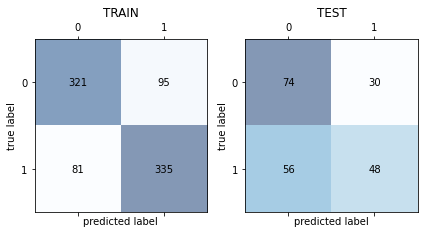

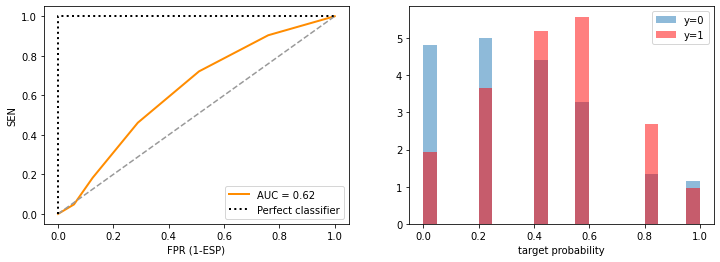



---DTC---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	100.00	46.15
SEN:	100.00	35.58
ESP:	100.00	56.73
PPV:	100.00	45.12
F1:	100.00	39.78


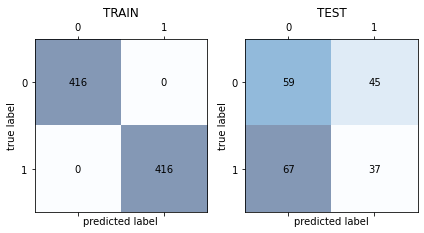

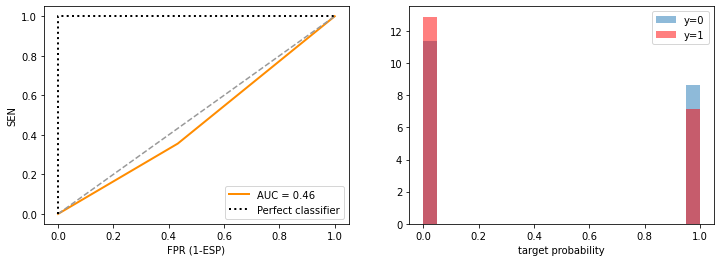



---RFC---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	100.00	51.92
SEN:	100.00	35.58
ESP:	100.00	68.27
PPV:	100.00	52.86
F1:	100.00	42.53


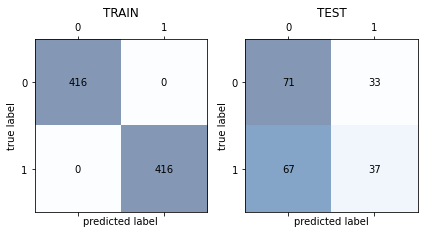

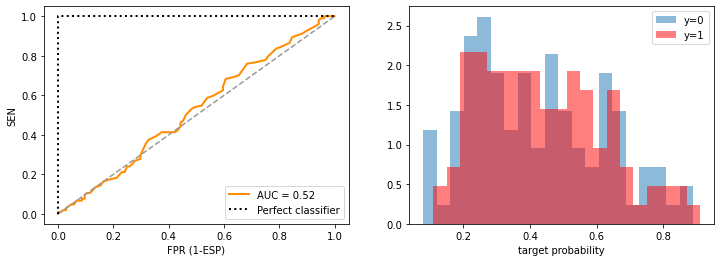



---GBT---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	92.43	50.96
SEN:	92.55	37.50
ESP:	92.31	64.42
PPV:	92.33	51.32
F1:	92.44	43.33


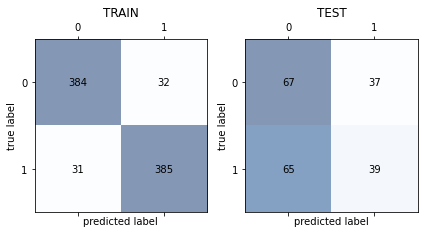

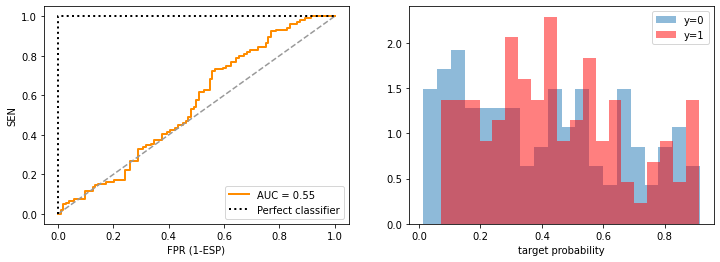



---MLP---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	79.69	61.06
SEN:	82.93	49.04
ESP:	76.44	73.08
PPV:	77.88	64.56
F1:	80.33	55.74


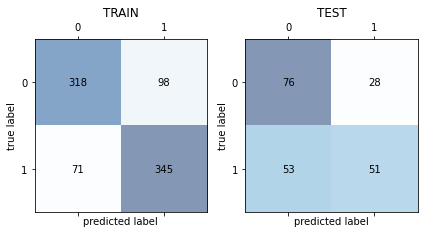

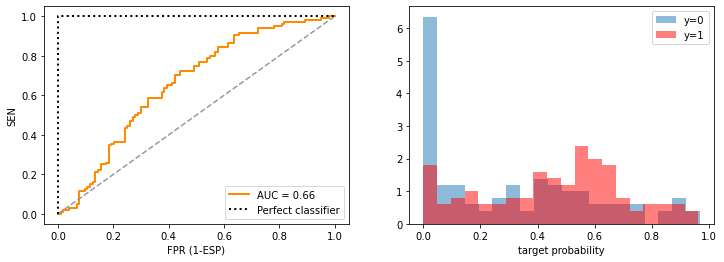

In [16]:
# Entrenamos los modelos con el subset de entrenamiento para comprobar su idoneidad evaluándolo con el subset de test
model_dict = {}                                  # Diccionario que contendrá toda la información de cada modelo

# Código ANSI para texto en negrita y para restablecer el formato
negrita = "\033[1m"
reset_formato = "\033[0m"

for name, model in models:                       # Iteramos sobre la lista de modelos creada en la celda anterior
    
    # Normalize only for those models where it is needed
    if name != 'DTC' and name != 'RFC':
        X_train, y_train, X_test, y_test = u.apply_norm('ss', X_train_prime[best_features], X_test_prime[best_features], y_train_prime, y_test_prime)
    else:
        X_train, y_train, X_test, y_test = X_train_prime[best_features], y_train_prime, X_test_prime[best_features], y_test_prime
        
    md = model.fit(X_train, y_train)             # Entrenamos el modelo
    
    model_dict[name] = {}                        # Metemos un diccionario por cada modelo dentro de nuestro diccionario original
    
    # Metemos un diccionario para los valores calculados de "training"
    model_dict[name]["training"] = {} 

    acc_train, sen_train, esp_train, ppv_train, fsc_train = u.get_metrics(confusion_matrix(y_train, md.predict(X_train)))
    acc_test, sen_test, esp_test, ppv_test, fsc_test = u.get_metrics(confusion_matrix(y_test, md.predict(X_test)))
    
    # Por último, añadimos al diccionario todas las métricas para la evaluación de la idoneidad del modelo
    model_dict[name]["training"]["accuracy"] = (acc_train, acc_test)
    model_dict[name]["training"]["sensitivity"] = (sen_train, sen_test)
    model_dict[name]["training"]["precision"] = (esp_train, esp_test)
    model_dict[name]["training"]["recall"] = (ppv_train, ppv_test)
    model_dict[name]["training"]["f1"] = (fsc_train, fsc_test)
    
    print(f"---{negrita}{name.upper()}{reset_formato}---")
    u.analyze_train_test_performance(model, X_train, X_test, y_train, y_test)
    print('\n')

Ending with the training phase we can show an evaluation of each of the base models, containing the metrics explained before.

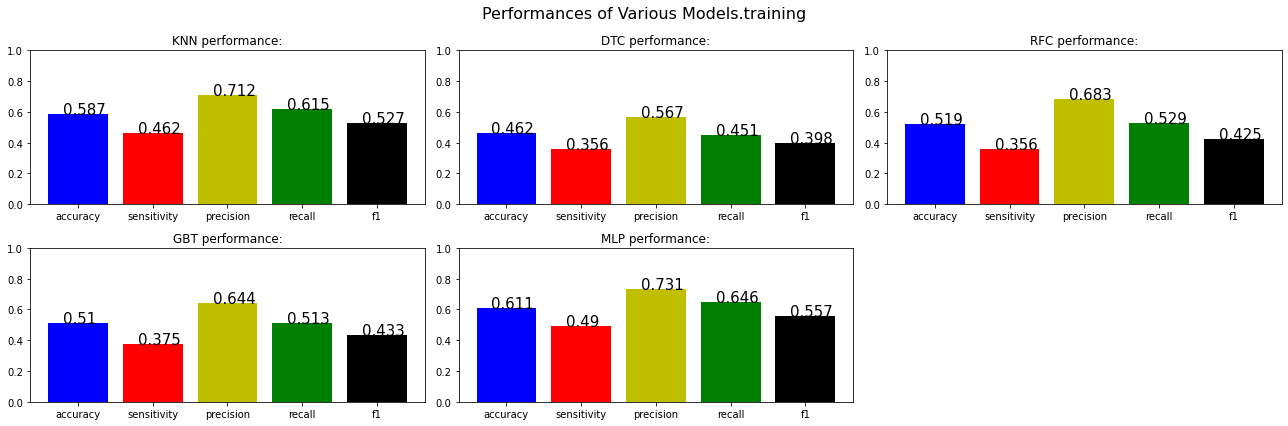

In [17]:
# Evaluation of the base models in the training phase
u.evaluate_models(model_dict, 'training')

## 4. Model validation

Validation is a crucial step in the model development process, serving a dual purpose of assessing model performance and mitigating overfitting. While the primary goal of validation is to evaluate how well a model generalizes to unseen data, it also plays a pivotal role in improving performance. 

Models that perform exceptionally well on the training phase may suffer from overfitting, a phenomenon where they memorize the training data but struggle to generalize to new, unseen data. Validation allows for the identification of overfitting by comparing a model's performance on a separate validation or test set against its training set performance. 

In instances where there is a significant disparity between training and test set results, as seen previously in the training phase, it indicates that the model is likely overfitted, prompting the need for adjustments to enhance generalization capabilities and improve overall performance on new, unseen data.

In our validation phase, we employ a systematic approach to assess and enhance the performance of our machine learning models.

### STEP 1: cross_validate

The first step involves using the `cross_validate` method, which utilizes techniques such as Stratified K-Fold to split the dataset into multiple folds, allowing us to evaluate the model's performance across different subsets of the data. This provides a comprehensive understanding of the model's behavior and its ability to generalize.

In [18]:
# Calculamos por validación cruzada las métricas para cada una de los modelos
scorers = list(model_dict["KNN"]["training"].keys())        # Creamos una lista con las métricas que queremos calcular
scorers.remove('sensitivity')
for name, model in models:                                  # Iteramos sobre la lista de modelos creada durante el entrenamiento
    # Añadimos al diccionario con la información un nuevo diccionario de validación cruzada y guardamos las métricas
    model_dict[name]["cross_validation"] = u.crossValidate(model, X_train_prime[best_features], y_train_prime, scoring=scorers)

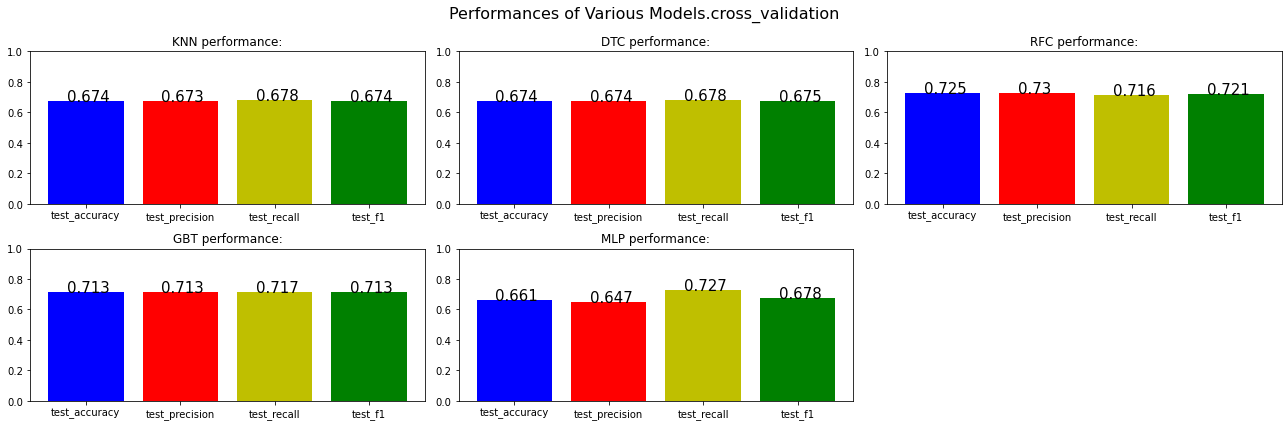

In [19]:
u.evaluate_models(model_dict, 'cross_validation')

### STEP 2: GridSearchCV

Following, the second step involves the application of `GridSearchCV`, a technique that systematically explores a predefined hyperparameter grid to find the optimal combination that maximizes model performance. This process helps fine-tune the model and select the most effective set of hyperparameters.

The explanation of each of the hyperparameters of the models chosen for this project are explained in the document 'README'.

In [20]:
params = {
    'KNN': {
        'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
        'p': np.linspace(1, 2, 2, dtype=int),
        'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
        'weights': ('uniform', 'distance')
    },
    'DTC': {
        'max_depth': np.linspace(1, 50, 5, dtype=int),
        'min_samples_split': np.linspace(2, 10, 5, dtype=int),
        'min_samples_leaf': np.linspace(2, 10, 5, dtype=int),
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random']
    },
    'RFC': {
        'n_estimators': np.linspace(1, 200, 4, dtype=int),
        'max_depth': np.linspace(2, 20, 5, dtype=int),
        'min_samples_split': np.linspace(2, 10, 5, dtype=int),
        'min_samples_leaf': np.linspace(2, 10, 5, dtype=int),
        'criterion': ['gini', 'entropy']
    },
    'GBT': {
        'n_estimators': np.linspace(10, 100, 5, dtype=int),
        'learning_rate': np.logspace(-3, 0, 3),
        'max_depth': np.linspace(3, 20, 5, dtype=int),
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['identity', 'logistic', 'relu', 'tanh'],
        'alpha': np.logspace(-4, 0, 5),
    }
}

In [21]:
# Código ANSI para texto en negrita y para restablecer el formato
negrita = "\033[1m"
reset_formato = "\033[0m"

# Ahora hallamos los mejores hiperparámetros con GridSearchCV
n_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)  # Establecemos los folds para el GridSearchCV

for name, model in models:                                             # Iteramos sobre los nombres y modelos de la lista
    print(f"---{negrita}{name}{reset_formato}---")
    tuned_params = params[name]                                        # Escogemos los parámetros de cada modelo
    
    # Normalize only for those models where it is needed
    if name != 'DTC' and name != 'RFC':
        X_train, y_train, X_test, y_test = u.apply_norm('ss', X_train_prime[best_features], X_test_prime[best_features], y_train_prime, y_test_prime)
    else:
        X_train, y_train, X_test, y_test = X_train_prime[best_features], y_train_prime, X_test_prime[best_features], y_test_prime
    
    # Computing the grid with our personalized function
    grid = u.hyper_parameters_search(model, X_train, y_train, tuned_params)
    
    # Plotting the cv score
    #for param in tuned_params:
     #   plot_cv_scoring(grid, param, plot_errors=True)
    
    # Guardamos los valores computados en el diccio  nario de modelos: tiempo de entrenamiento, mejor resultado y mejor modelo
    model_dict[name]['cross_validation']['best_score'] = grid.best_score_
    model_dict[name]['cross_validation']['best_model'] = grid.best_estimator_
    
    # Mostramos por pantalla cada vez que se complete un modelo
    print(name, "COMPLETADO")

---KNN---
best mean cross-validation score: 0.689
best parameters: {'algorithm': 'auto', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
KNN COMPLETADO
---DTC---
best mean cross-validation score: 0.611
best parameters: {'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 10, 'min_samples_split': 6, 'splitter': 'random'}
DTC COMPLETADO
---RFC---
best mean cross-validation score: 0.743
best parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 133}
RFC COMPLETADO
---GBT---
best mean cross-validation score: 0.730
best parameters: {'learning_rate': 1.0, 'max_depth': 11, 'n_estimators': 32}
GBT COMPLETADO
---MLP---
best mean cross-validation score: 0.704
best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
MLP COMPLETADO


### STEP 3: cross_val_score

Lastly, we utilize `cross_val_score` to obtain a single performance metric, enabling a concise evaluation of the model's effectiveness across multiple folds. These three steps collectively form a robust validation strategy, offering insights into the model's generalization capabilities and guiding the refinement of its parameters for optimal predictive accuracy.

Now we evaluate the performance of the models. First, with those that have not gone through GridSearchCV.

In [22]:
# Evaluamos los modelos antiguos y mostramos por pantalla
results = {}                                                          # Establecemos un diccionario
print("MODEL PERFORMANCES .....")
for name, model in models:                                            # Iteramos sobre los nombres y modelos
    scores = u.crossValidate2(model, X_train, y_train, 'accuracy')      # Calculamos el resultado de la validación cruzada
    results[name] = scores                                            # Guardamos dicho resultado en el diccionario antes creado
    print("%s %.3f (%.3f)" % (name, np.mean(scores), np.std(scores))) # Enseñamos por pantalla

MODEL PERFORMANCES .....
KNN 0.669 (0.043)
DTC 0.655 (0.045)
RFC 0.735 (0.052)
GBT 0.726 (0.047)
MLP 0.702 (0.041)


Now, we evaluate the models which have gone through GridSearchCV.

In [23]:
# Evaluamos los nuevos modelos y mostramos por pantalla
results_CV = {}                                                       # Establecemos un diccionario
print("MODEL PERFORMANCES .....")
for name in model_dict:                                               # Iteramos sobre los nombres de los modelos
    model = model_dict[name]['cross_validation']['best_model']        # Cogemos el mejor modelo calculado por GridSearch CV
    scores = u.crossValidate2(model, X_train, y_train, 'accuracy')      # Calculamos el resultado de la validación cruzada
    results_CV[name] = scores                                         # Guardamos dicho resultado en el diccionario antes creado
    print("%s %.3f (%.3f)" % (name, np.mean(scores), np.std(scores))) # Enseñamos por pantalla

MODEL PERFORMANCES .....
KNN 0.702 (0.054)
DTC 0.647 (0.055)
RFC 0.729 (0.051)
GBT 0.733 (0.042)
MLP 0.702 (0.053)


Afterward, we compare the results of the baseline models with the new models validated with GridSearchCV and save the one that is better (between the baseline and the new one).

In [24]:
# Comparamos modelos base y nuevos modelos validados
scores = []                                                                            # Establecemos una lista
for name, model in models:                                                             # Iteramos sobre los nombres y modelos
    # Cuerpo if-else para encontrar el mejor modelo
    if np.mean(results[name]) > np.mean(results_CV[name]): # Caso de que los modelos base sean mejores
        scores.append(results[name])                                                   # Guardamos los resultados del modelo base en la lista
        model_dict[name]['cross_validation']['accuracy_2'] = np.mean(results[name])    # Guardamos la media de los resultados en el diccionario
        model_dict[name]['cross_validation']['best_model'] = model                     # Guardamos el modelo base en caso de ser mejor en el diccionario
        print("For", name, "the best model is the base one.")           # Mostramos por pantalla si ha sido mejor el modelo base
    else: # Caso de que los modelos validados sean mejores o que ambos modelos tengan la misma media de métricas
        scores.append(results_CV[name])                                                # Guardamos los resultados del modelo validado en la lista
        model_dict[name]['cross_validation']['accuracy_2'] = np.mean(results_CV[name]) # Guardamos la media de los resultados en el diccionario
        print("For", name, "the best model is the one validated by GridSearchCV.")        # Mostramos por pantalla si ha sido mejor el modelo validado

For KNN the best model is the one validated by GridSearchCV.
For DTC the best model is the base one.
For RFC the best model is the base one.
For GBT the best model is the one validated by GridSearchCV.
For MLP the best model is the one validated by GridSearchCV.


We represent the results, both in a boxplot and in a bar graph.

In [25]:
# Guardamos en una lista los nombres de los modelos y las métricas (accuracy_2)
names, mean_scores =  [], []                                                         # Establecemos dos listas
for name in model_dict:                                                              # Iteramos sobre los nombres de los modelos
    names.append(name)                                                               # Guardamos dichos nombres 
    mean_scores.append(np.mean(model_dict[name]['cross_validation']['accuracy_2']))  # Guardamos la media de la métrica
    #scores.append(model_dict[name]['cross_validation']['accuracy_2'])               # Guardamos las métricas 

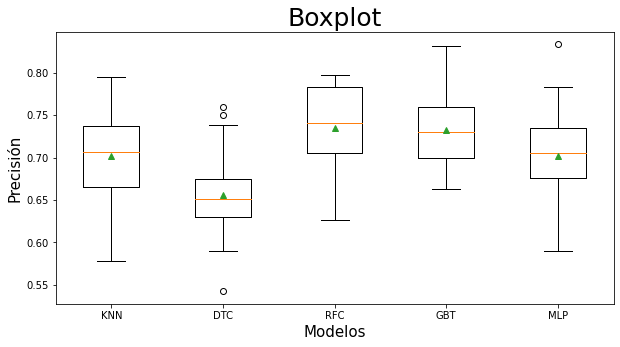

In [26]:
# Representamos el boxplot
plt.figure(figsize=(10, 5))
# Para la gráfica boxplot utilizamos la lista de los mejores resultados creada durante la comparación de modelos, 
# ya que posee los resultados para cada uno de los folds
plt.boxplot(scores, labels=names, showmeans=True)   
plt.title("Boxplot", fontsize=25)
plt.xlabel("Modelos", fontsize=15)
plt.ylabel("Precisión", fontsize=15)
plt.show()

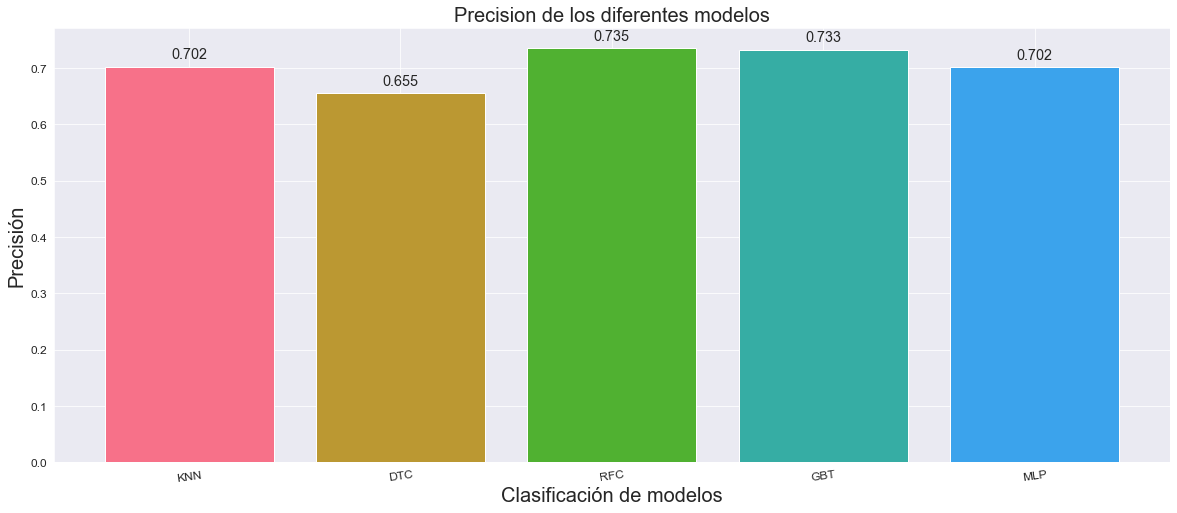

In [27]:
# Representamos el gráfico de barras
plt.rcParams['figure.figsize']=20,8
sns.set_style('darkgrid')
# Para el gráfico de barras utilizamos la lista con la media de las métricas de cada modelo
ax = plt.bar(names, mean_scores, color=sns.husl_palette())
plt.xlabel('Clasificación de modelos', fontsize = 20 )
plt.ylabel('Precisión', fontsize = 20)
plt.title('Precision de los diferentes modelos', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    plt.annotate(f'{round(height,3)}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

## 5. Ensemble

Ensemble methods, also known as ensemble techniques, are approaches in the field of machine learning that combine multiple base models to enhance predictive performance and the generalization of the final model. Instead of relying on a single model, ensembles leverage the diversity of various models and their ability to make independent predictions, such as the already seen Random Forest and Gradient Boosting.

There are different types of ensembles, but in general, they follow the principle of "wisdom of the crowd." Each base model in the ensemble can be an entire individual model, such as decision trees, logistic regression, support vector machines, neural networks, etc., or they can even be simpler models, such as weak learners in the case of boosting.

Ensembles can be classified into two main categories.

1. **Average Ensembles** combine individual predictions of base models by averaging their results, which can reduce variance and improve overall accuracy. Examples of average ensembles include simple averaging, weighted averaging, and bagging.

2. **Voting Ensembles** combine predictions of base models by taking the majority of votes or averaging classification probabilities. These ensembles are effective for classification problems and can handle different types of voting, such as hard voting and soft voting. Examples of voting ensembles include majority voting, weighted voting, and boosting.

The advantage of using ensembles is that they can improve the generalization ability of the final model by reducing bias and variance. Additionally, ensembles can handle imbalanced datasets, detect and correct errors from base models, and capture more complex nonlinear relationships.

In this context, the `VotingClassifier` from the `sklearn` library will be used.

7. **VotingClassifier:** `VotingClassifier` is an ensemble algorithm in machine learning that combines multiple classification models to make predictions. It works by voting on the results of various individual classifiers and selects the class with the majority of votes as the final prediction. There are two main types of voting in `VotingClassifier`:

**I. Hard Voting**:
- In this approach, each individual classifier in the ensemble casts a vote for the predicted class.
- The class receiving the majority of votes is selected as the final prediction.
- It is especially effective when individual classifiers have different strengths and weaknesses and can complement each other.

**II. Soft Voting**:  
- In this approach, instead of voting for classes, individual classifiers vote for the probabilities of belonging to each class.
- Then, the probabilities from all classifiers are averaged, and the class with the highest probability is selected.
- Soft voting tends to be more accurate than hard voting as it uses probability information rather than binary decisions.
   
`VotingClassifier` can combine different types of classifiers, such as decision trees, logistic regression, SVM, among others, and can be used in binary or multiclass classification problems like this project.

An advantage of `VotingClassifier` is that it allows leveraging the diversity of individual classifiers to obtain a more robust and generalized model. Furthermore, by combining multiple classifiers, it can reduce the risk of overfitting and improve performance on diverse datasets.

It is important to note that the performance of `VotingClassifier` depends on the quality and diversity of the individual classifiers used in the ensemble. Therefore, the selection of base classifiers is a crucial aspect to achieve optimal results.

We add the new model to the list of models and the dictionary, train, and evaluate it.

In [28]:
# Primero haremos una lista con los mejores modelos para sustituir los modelos base
best_models = []
for name in model_dict:
    best_models.append((name, model_dict[name]["cross_validation"]["best_model"]))

In [29]:
# Añadimos el modelo de ensamblaje al diccionario
ensemble = VotingClassifier(estimators=best_models, voting="soft")
model_dict["VCC"] = {
    "model": ensemble, 
    "ensemble": {}
}

---VCC---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	100.00	50.00
SEN:	100.00	34.62
ESP:	100.00	65.38
PPV:	100.00	50.00
F1:	100.00	40.91


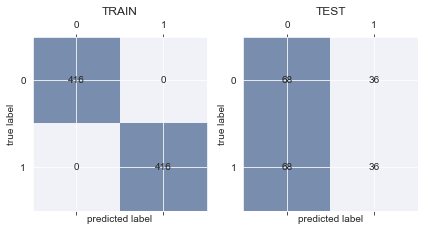

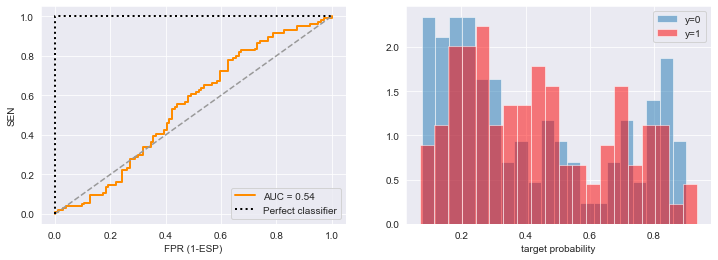

In [30]:
# Código ANSI para texto en negrita y para restablecer el formato
negrita = "\033[1m"
reset_formato = "\033[0m"

em = ensemble.fit(X_train_prime[best_features], y_train_prime)       # Entrenamos el modelo

X_train, y_train, X_test, y_test = u.apply_norm('ss', X_train_prime[best_features], X_test_prime[best_features], y_train_prime, y_test_prime)

acc_train, sen_train, esp_train, ppv_train, fsc_train = u.get_metrics(confusion_matrix(y_train_prime, md.predict(X_train_prime[best_features])))
acc_test, sen_test, esp_test, ppv_test, fsc_test = u.get_metrics(confusion_matrix(y_test_prime, md.predict(X_test_prime[best_features])))
    
# Por último, añadimos al diccionario todas las métricas para la evaluación de la idoneidad del modelo
model_dict["VCC"]["ensemble"]["accuracy"] = (acc_train, acc_test)
model_dict["VCC"]["ensemble"]["sensitivity"] = (sen_train, sen_test)
model_dict["VCC"]["ensemble"]["precision"] = (esp_train, esp_test)
model_dict["VCC"]["ensemble"]["recall"] = (ppv_train, ppv_test)
model_dict["VCC"]["ensemble"]["f1"] = (fsc_train, fsc_test)
    
print(f"---{negrita}VCC{reset_formato}---")
u.analyze_train_test_performance(ensemble, X_train_prime[best_features], X_test_prime[best_features], y_train_prime, y_test_prime)

However, as seen above the results still to be mediocre, even after applying other type of ensemble methods.

## 6. Some required concerns

Before evaluating the performance of our model we delve into some concerns that are asked in the project.

### ***Tree visualization of the Decision Tree Classifier (DTC)***

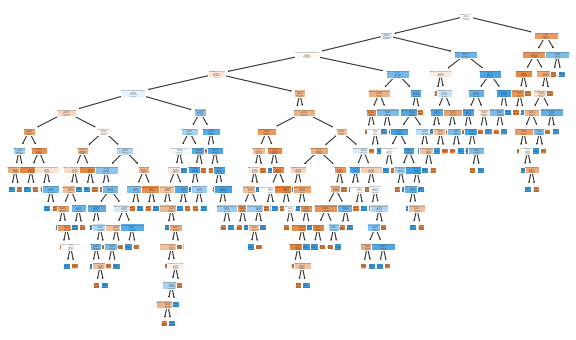

In [31]:
from sklearn.tree import plot_tree

# set plot dimensions
plt.figure(figsize=(10,6))

plot_tree(
    model_dict['DTC']['cross_validation']['best_model'],
    feature_names=best_features,
    class_names=['PD','Healthy'],
    filled=True
)

plt.show()

### ***Feature importances***

***Regarding Decision Tree Classifier (DTC)***

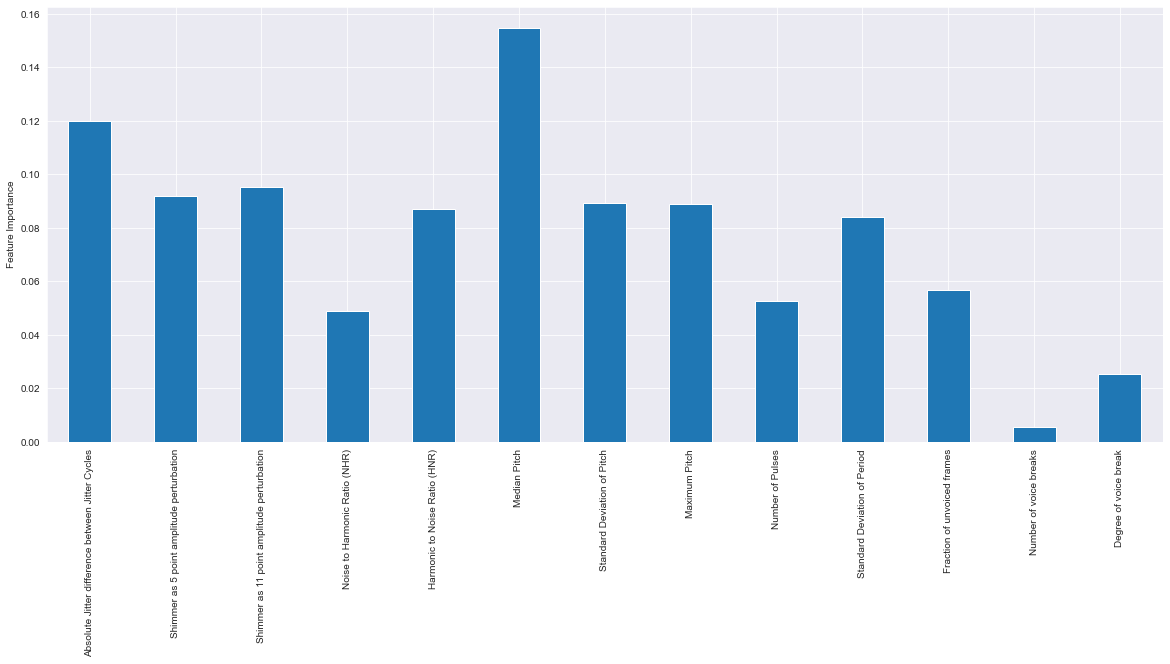

In [32]:
# Plot feature importance
u.plot_importances(model_dict['DTC']['cross_validation']['best_model'].feature_importances_, best_features)

***Regarding Decision Random Forest Classifier (RFC)***

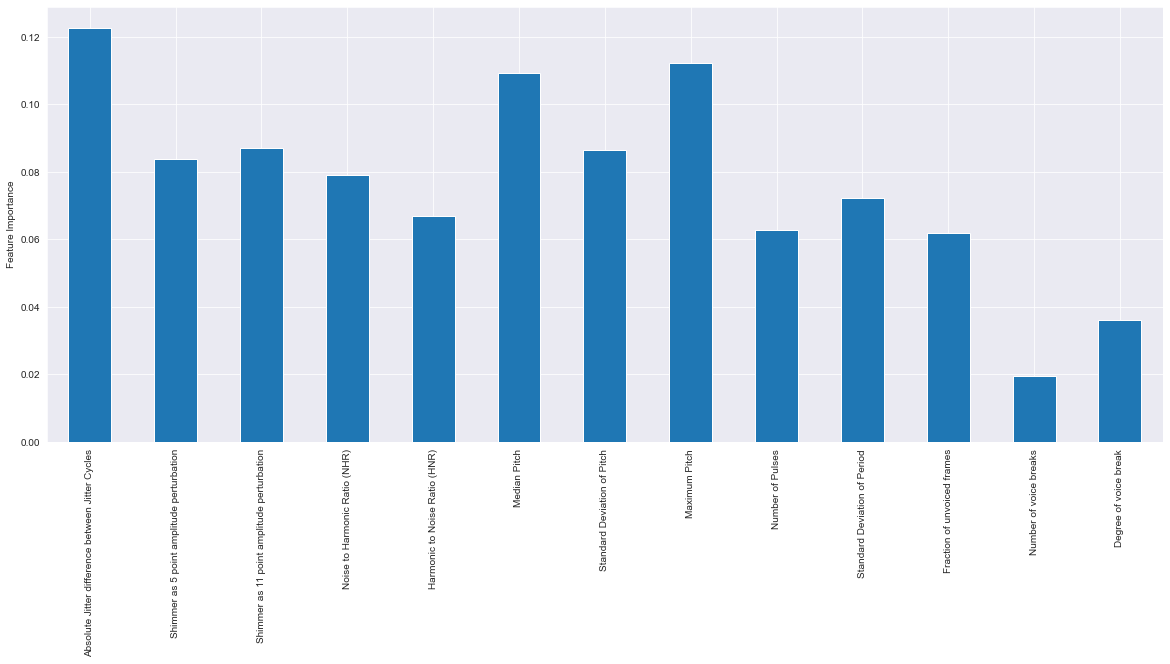

In [33]:
# Plot feature importance
u.plot_importances(model_dict['RFC']['cross_validation']['best_model'].feature_importances_, best_features)

## 7. Model evaluation

For the evaluation of every model, we use the previously presented metrics, showing how each model predicts unseen data. At the same time, we store in our dictionary the results, and compute a mean of each metric used for the evaluaion in order to compare between the models and choose the best one.

---KNN---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	51.56	47.60
SEN:	99.28	93.27
ESP:	3.85	1.92
PPV:	50.80	48.74
F1:	67.21	64.03


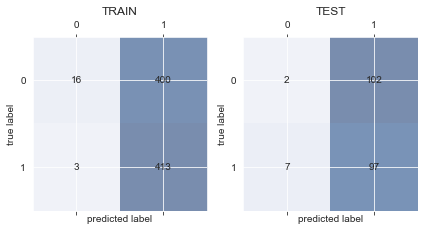

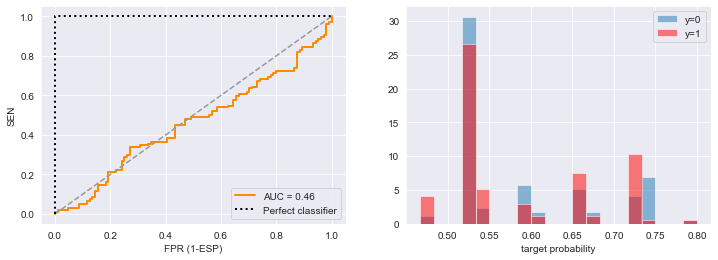

---DTC---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	100.00	46.15
SEN:	100.00	35.58
ESP:	100.00	56.73
PPV:	100.00	45.12
F1:	100.00	39.78


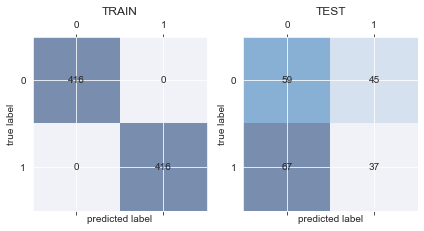

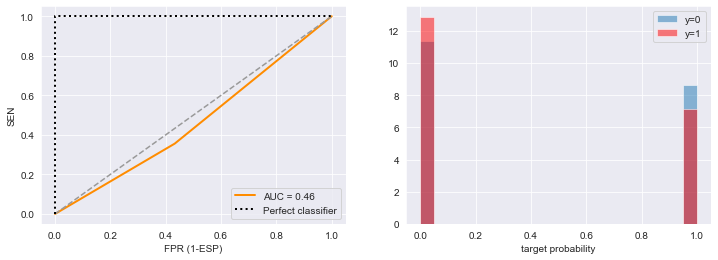

---RFC---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	100.00	51.92
SEN:	100.00	35.58
ESP:	100.00	68.27
PPV:	100.00	52.86
F1:	100.00	42.53


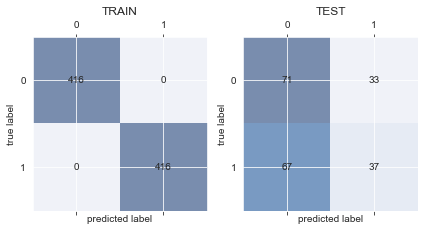

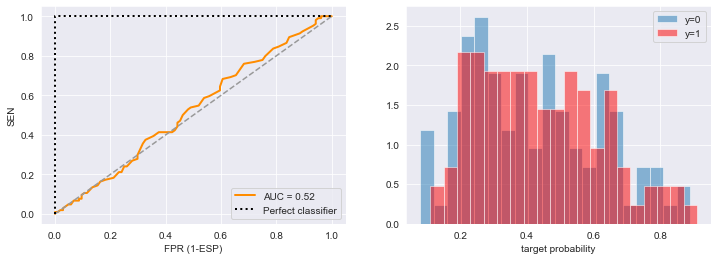

---GBT---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	49.04	55.29
SEN:	58.41	59.62
ESP:	39.66	50.96
PPV:	49.19	54.87
F1:	53.41	57.14


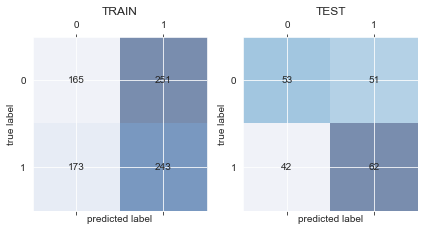

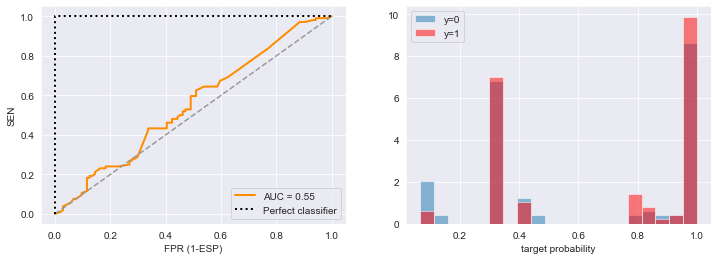

---MLP---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	50.60	50.00
SEN:	6.73	3.85
ESP:	94.47	96.15
PPV:	54.90	50.00
F1:	11.99	7.14


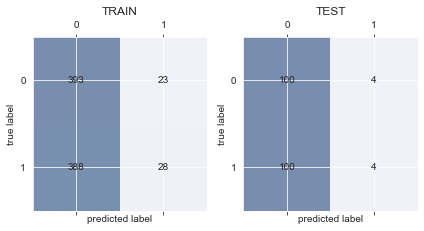

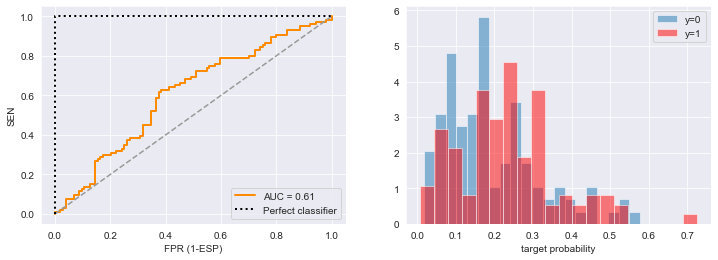

---VCC---
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	100.00	50.00
SEN:	100.00	34.62
ESP:	100.00	65.38
PPV:	100.00	50.00
F1:	100.00	40.91


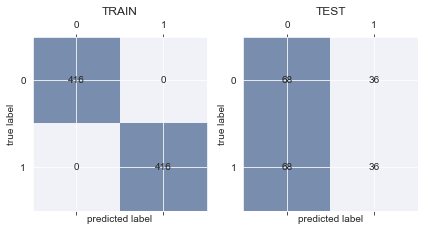

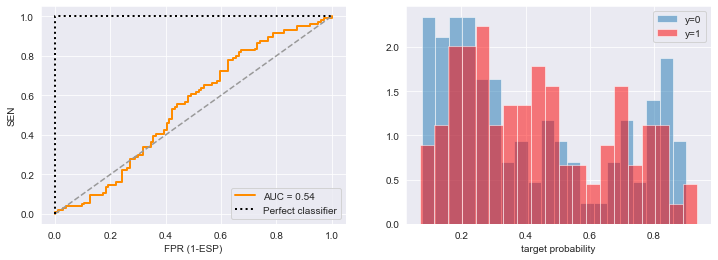

In [48]:
best_score = -float('inf')   # Establish a variable for the best result
for name in model_dict:       # Iterate over the model names
    # If-else block to determine whether we encounter the ensemble model or others
    if name != "VCC":
        model = model_dict[name]["cross_validation"]["best_model"]
    else:
        model = model_dict[name]["model"]
        
    # Normalize only for those models where it is needed
    if name != 'DTC' and name != 'RFC':
        X_train, y_train, X_test, y_test = u.apply_norm('ss', X_train_prime[best_features], X_test_prime[best_features], y_train_prime, y_test_prime)
    else:
        X_train, y_train, X_test, y_test = X_train_prime[best_features], y_train_prime, X_test_prime[best_features], y_test_prime
    
    y_pred = model.predict(X_test)     # Make a prediction for each model
    
    # We display the evaluation of all the models
    print(f"---{negrita}{name}{reset_formato}---")
    u.analyze_train_test_performance(model, X_train_prime[best_features], X_test_prime[best_features], y_train_prime, y_test_prime)
    
    # Create the 'test' key in the dictionary
    model_dict[name]["test"] = {}
    # Save the metrics in the dictionary
    model_dict[name]["test"]["accuracy"] = accuracy_score(y_test, y_pred)
    model_dict[name]["test"]["precision"] = precision_score(y_test, y_pred)
    model_dict[name]["test"]["recall"] = recall_score(y_test, y_pred)
    model_dict[name]["test"]["f1"] = f1_score(y_test, y_pred)
    
    # Save the mean of the metrics in a variable
    score = np.mean([
        model_dict[name]["test"]["accuracy"], 
        model_dict[name]["test"]["precision"], 
        model_dict[name]["test"]["recall"], 
        model_dict[name]["test"]["f1"]
    ])
    # Choose the best model
    if score > best_score:
        best_score = score
        best_model_name = name
        best_model = model

In [50]:
# Guardamos en una lista los nombres de los modelos y las métricas
names, mean_scores = [], []                       # Establecemos dos listas
for name in model_dict:                           # Iteramos sobre los nombres de los modelos
    names.append(name)                            # Guardamos dichos nombres 
    mean_scores.append(np.mean([                       # Guardamos las métricas
        model_dict[name]["test"]["accuracy"],
        model_dict[name]["test"]["recall"],
        model_dict[name]["test"]["precision"],  
        model_dict[name]["test"]["f1"]
    ])) 

It can also be plotted the mean of each metric of every of the implemented models.

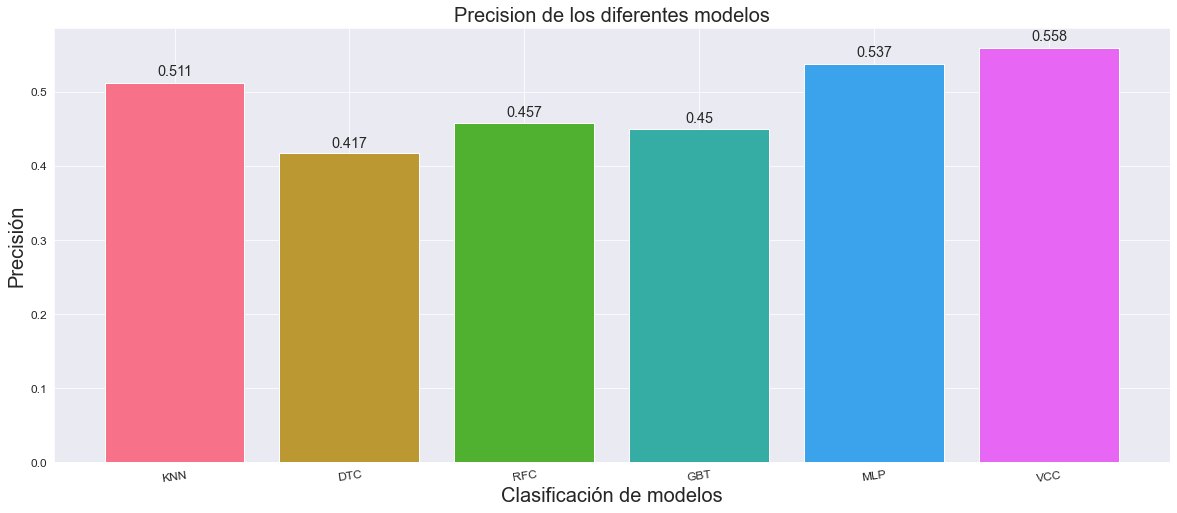

In [51]:
# Representamos el gráfico de barras
plt.rcParams['figure.figsize']=20,8
sns.set_style('darkgrid')
# Para el gráfico de barras utilizamos la lista con la media de las métricas de cada model
ax = plt.bar(names, mean_scores, color=sns.husl_palette())
sns.set_style('darkgrid')
plt.xlabel('Clasificación de modelos', fontsize = 20)
plt.ylabel('Precisión', fontsize = 20)
plt.title('Precision de los diferentes modelos', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment='center', rotation=8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    plt.annotate(f'{round(height,3)}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

We can also show the true vs false rate as taugh in the pratical sessions.

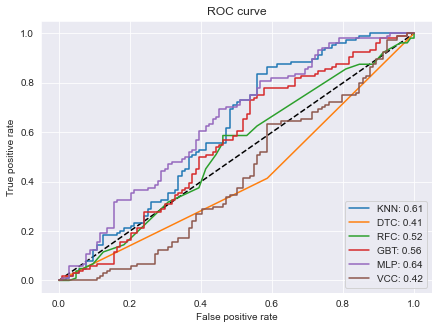

In [52]:
model_eval = {}

for name in model_dict:       # Iteramos sobre los nombres de los modelos
    # Cuerpo de if-else para saber si nos encontramos con el modelo ensamblaje o el resto
    if name != "VCC":
        model = model_dict[name]["cross_validation"]["best_model"]
    else:
        model = model_dict[name]["model"]
        
    model_eval[name] = model

plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--')
for k,v in model_eval.items():
    fpr, tpr,_ = roc_curve(y_test, model_eval[k].predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = k + ': %0.2f' % roc_auc)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Finally, the best model can also be shown.

In [53]:
print("The best model is {} ({}).".format(name_mejor_modelo, mejor_modelo))

The best model is VCC (VotingClassifier(estimators=[('KNN',
                              KNeighborsClassifier(n_neighbors=15, p=1,
                                                   weights='distance')),
                             ('DTC', DecisionTreeClassifier()),
                             ('RFC', RandomForestClassifier()),
                             ('GBT',
                              GradientBoostingClassifier(learning_rate=1.0,
                                                         max_depth=11,
                                                         n_estimators=32)),
                             ('MLP',
                              MLPClassifier(activation='tanh',
                                            hidden_layer_sizes=(50,)))],
                 voting='soft')).
